In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import ttest_rel

from utils import *

%load_ext autoreload
%autoreload 2
sns.set_context("talk")


## Load in

In [297]:
DATA_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/data")

cols_of_interest = [
    "condition_name",
    "number_of_readmissions",
    "number_of_discharges",
    "avg_medicare_beneficiaries_py",
    "payment",
    "beneficiary_avg_age",
    "avg_number_female_beneficiaries_py",
    "pct_beneficiaries_arthritis",
    # "pct_beneficiaries_afib",
    "pct_beneficiaries_alzheimers",
    # "pct_beneficiaries_cancer",
    # "pct_beneficiaries_chronic_kidney_disease",
    "pct_beneficiaries_congestive_heart_failure",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_depression",
    # "pct_beneficiaries_diabetes",
    "pct_beneficiaries_osteoporosis",
    "pct_beneficiaries_arthritis",
    # "pct_beneficiaries_psychotic_disorders",
    "pct_beneficiaries_stroke",
    "avg_number_beneficiaries_medicare_medicaid_py",
    # "avg_number_beneficiaries_medicare_only_py",
    "avg_number_white_beneficiaries_py",
    "avg_number_black_beneficiaries_py",
    "avg_number_hispanic_beneficiaries_py",
]

df = pd.read_csv(
    (DATA_PATH / "obt_slim.csv"),
    usecols=cols_of_interest,
)

# drop nans
df.dropna(inplace=True)

# query for hf

df = df.query("condition_name == 'Heart Failure'")

In [298]:
# calculate readmission rate & drop the original columns
df["readmission_rate"] = (
    df["number_of_readmissions"] / df["number_of_discharges"]
) * 100
df.drop(
    columns=["number_of_readmissions", "number_of_discharges"],
    inplace=True,
)

df["pct_female"] = (
    100 * df["avg_number_female_beneficiaries_py"] / df["avg_medicare_beneficiaries_py"]
)

df["pct_black"] = (
    100 * df["avg_number_black_beneficiaries_py"] / df["avg_medicare_beneficiaries_py"]
)
df["pct_hispanic"] = (
    100
    * df["avg_number_hispanic_beneficiaries_py"]
    / df["avg_medicare_beneficiaries_py"]
)
df["pct_medicare_medicaid"] = (
    100
    * df["avg_number_beneficiaries_medicare_medicaid_py"]
    / df["avg_medicare_beneficiaries_py"]
)

df["payment"] = df.payment.str.replace("$", "").str.replace(",", "").astype(float)

# df["pct_white"] = (
#     100 * df["avg_number_white_beneficiaries_py"] / df["avg_medicare_beneficiaries_py"]
# )
# df["pct_medicare_only"] = (
#     100
#     * df["avg_number_beneficiaries_medicare_only_py"]
#     / df["avg_medicare_beneficiaries_py"]
# )
# df["pct_non_white"] = 100 - df["pct_white"]

In [299]:
# right skewed dist -> log transform
log_transform = [
    # "pct_beneficiaries_psychotic_disorders",
    "pct_black",
    "pct_hispanic",
    # "pct_non_white",
]

# power_transform = ["pct_medicare_only"]

for col in log_transform:
    df[col] = np.log10(df[col])
# for col in power_transform:
#     df[col] = np.power(df[col], 2)

model_df = df.drop(
    columns=[
        "condition_name",
        "avg_medicare_beneficiaries_py",
        "avg_number_female_beneficiaries_py",
        "avg_number_white_beneficiaries_py",
        "avg_number_black_beneficiaries_py",
        "avg_number_hispanic_beneficiaries_py",
        "avg_number_beneficiaries_medicare_medicaid_py",
        # "pct_white",
        # "pct_black",
        # "pct_hispanic",
        # "avg_number_beneficiaries_medicare_only_py",
    ]
)

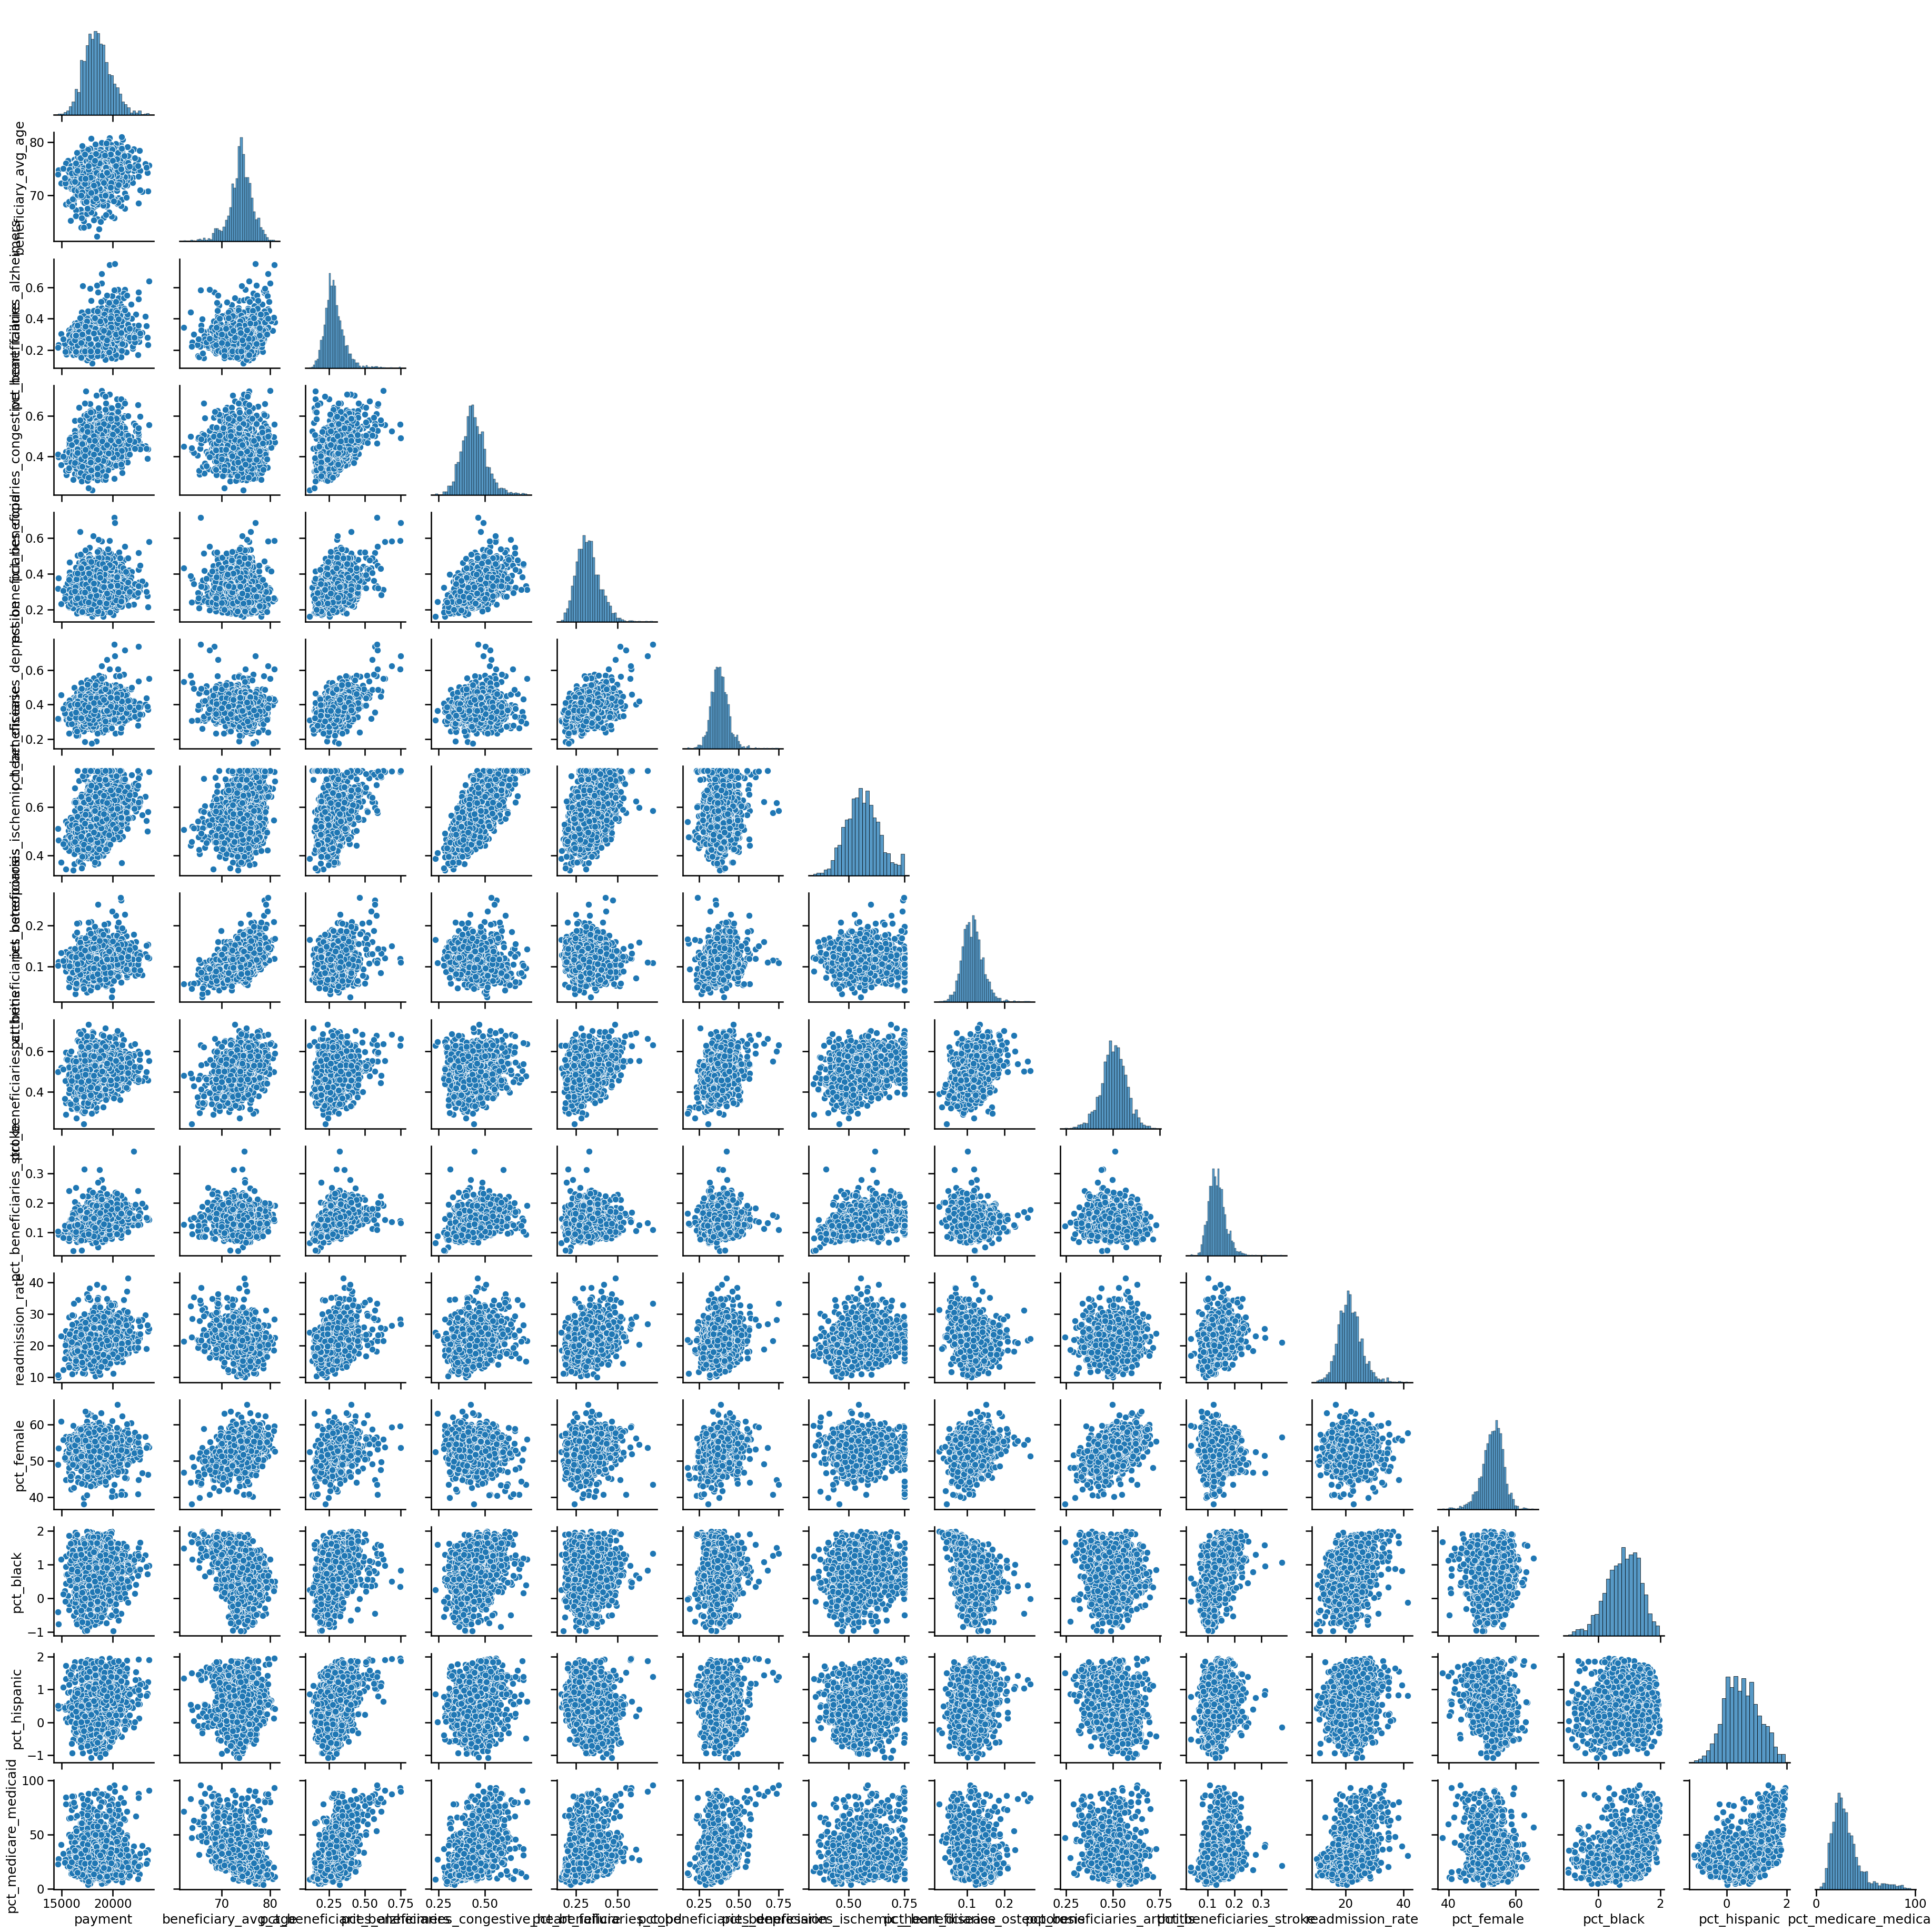

In [300]:
sns.pairplot(model_df, corner=True)

In [301]:
model_df.columns

Index(['payment', 'beneficiary_avg_age', 'pct_beneficiaries_alzheimers',
       'pct_beneficiaries_congestive_heart_failure', 'pct_beneficiaries_copd',
       'pct_beneficiaries_depression',
       'pct_beneficiaries_ischemic_heart_disease',
       'pct_beneficiaries_osteoporosis', 'pct_beneficiaries_arthritis',
       'pct_beneficiaries_stroke', 'readmission_rate', 'pct_female',
       'pct_black', 'pct_hispanic', 'pct_medicare_medicaid'],
      dtype='object')

## Feature Evaluation

In [302]:
X = model_df.drop(columns=["readmission_rate"])
X_standardized = process_features(
    X,
    numeric_cols=X.columns,
)
X_standardized.reset_index(drop=True, inplace=True)
y = df["readmission_rate"]
y.reset_index(drop=True, inplace=True)

X_w_bias = sm.add_constant(X_standardized)
linear_model = sm.OLS(y, X_w_bias)
linear_model = linear_model.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       readmission_rate   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     60.81
Date:                Thu, 20 Jul 2023   Prob (F-statistic):          1.67e-141
Time:                        11:41:13   Log-Likelihood:                -5022.7
No. Observations:                1914   AIC:                         1.008e+04
Df Residuals:                    1899   BIC:                         1.016e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                         21.5245      0.077    281.034      0.000      21.374      21.675
payment                                        0.5823      0.091      6.393      0.000       0.404       0.761
beneficiary_avg_age                           -0.9091      0.145     -6.261      0.000      -1.194      -0.624
pct_beneficiaries_alzheimers                   0.7575      0.160      4.732      0.000       0.444       1.072
pct_beneficiaries_congestive_heart_failure    -0.3898      0.125     -3.112      0.002      -0.635      -0.144
pct_beneficiaries_copd                         0.6616      0.118      5.597      0.000       0.430       0.893
pct_beneficiaries_depression                  -0.4301      0.111     -3.891      0.000      -0.647      -0.213
pct_beneficiaries_ischemic_heart_disease       0.4010      0.127      3.163      0.002       0.152       0.650
pct_beneficiaries_osteoporosis                -0.2136      0.104     -2.045      0.041      -0.418      -0.009
pct_beneficiaries_arthritis                    0.2394      0.107      2.248      0.025       0.031       0.448
pct_beneficiaries_stroke                       0.2380      0.102      2.344      0.019       0.039       0.437
pct_female                                     0.3209      0.104      3.077      0.002       0.116       0.525
pct_black                                      0.2657      0.113      2.356      0.019       0.044       0.487
pct_hispanic                                   0.1297      0.100      1.303      0.193      -0.065       0.325
pct_medicare_medicaid                          0.7132      0.132      5.397      0.000       0.454       0.972
==============================================================================
Omnibus:                       56.011   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               97.265
Skew:                           0.236   Prob(JB):                     7.57e-22
Kurtosis:                       3.998   Cond. No.                         5.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [303]:
get_significant_variables(linear_model)

Index(['payment', 'beneficiary_avg_age', 'pct_beneficiaries_alzheimers',
       'pct_beneficiaries_congestive_heart_failure', 'pct_beneficiaries_copd',
       'pct_beneficiaries_depression',
       'pct_beneficiaries_ischemic_heart_disease',
       'pct_beneficiaries_osteoporosis', 'pct_beneficiaries_arthritis',
       'pct_beneficiaries_stroke', 'pct_female', 'pct_black',
       'pct_medicare_medicaid'],
      dtype='object')

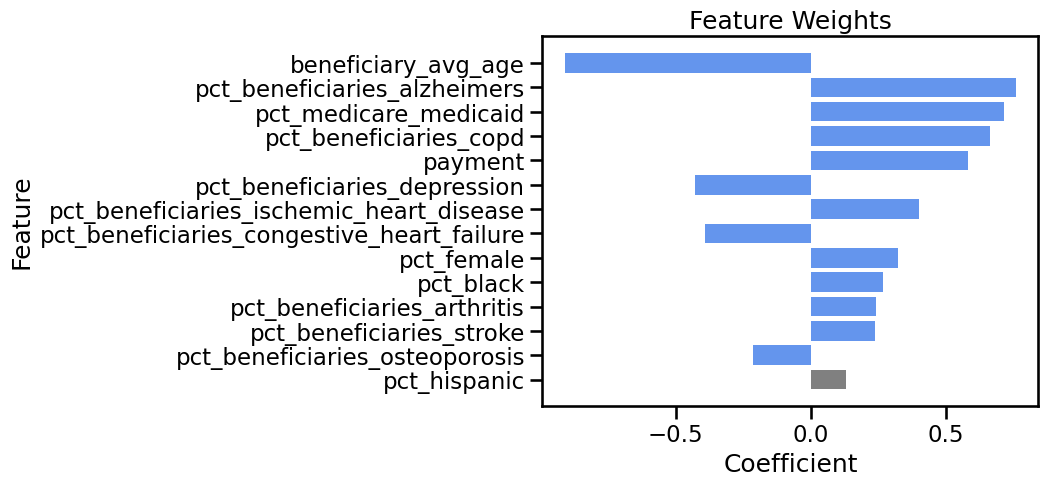

In [304]:
plot_feature_weights_horizontal_sm(linear_model)

Text(0.5, 1.0, 'Feature Weights')

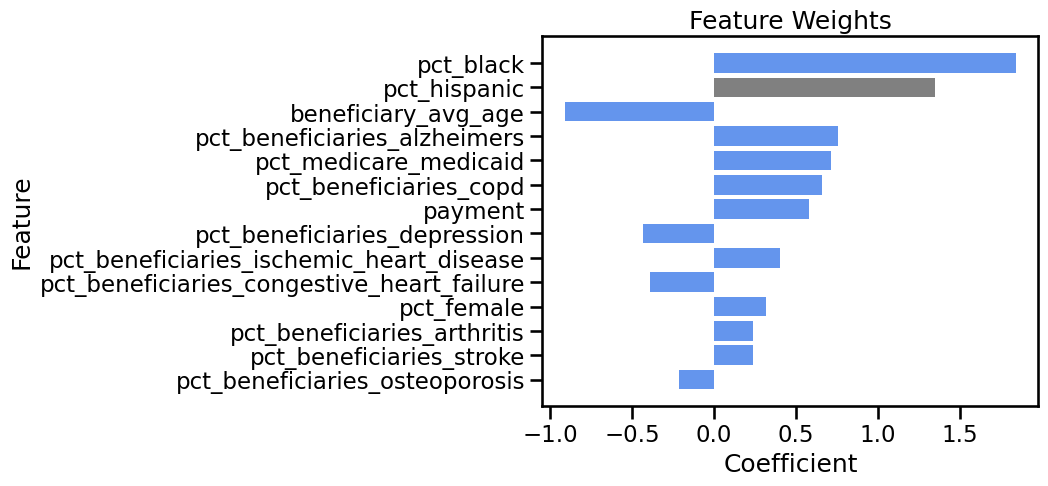

In [305]:
feature_names = linear_model.params.index[1:]  # Exclude the bias term
coefficients = linear_model.params[1:]

re_transformed_coefficeints = []
for fn in feature_names:
    if fn in log_transform:
        re_transformed_coefficeints.append(np.power(10, coefficients[fn]))
    elif fn in power_transform:
        re_transformed_coefficeints.append(np.sqrt(coefficients[fn]))
    else:
        re_transformed_coefficeints.append(coefficients[fn])
re_transformed_coefficeints = np.array(re_transformed_coefficeints)

# # Sort feature names and coefficients based on absolute coefficient values
sorted_indices = np.argsort(np.abs(re_transformed_coefficeints))
feature_names_sorted = feature_names[sorted_indices]
coefficients_sorted = re_transformed_coefficeints[sorted_indices]

significant_variables = get_significant_variables(linear_model)
# Set the color for significant and non-significant variables
colors = [
    "cornflowerblue" if var in significant_variables else "gray"
    for var in feature_names
]
colors = [colors[i] for i in sorted_indices]

# Plot the feature weights
fig, ax = plt.subplots()
ax.barh(feature_names_sorted, coefficients_sorted, color=colors)

# Set labels and title
ax.set_xlabel("Coefficient")
ax.set_ylabel("Feature")
ax.set_title("Feature Weights")

<Axes: >

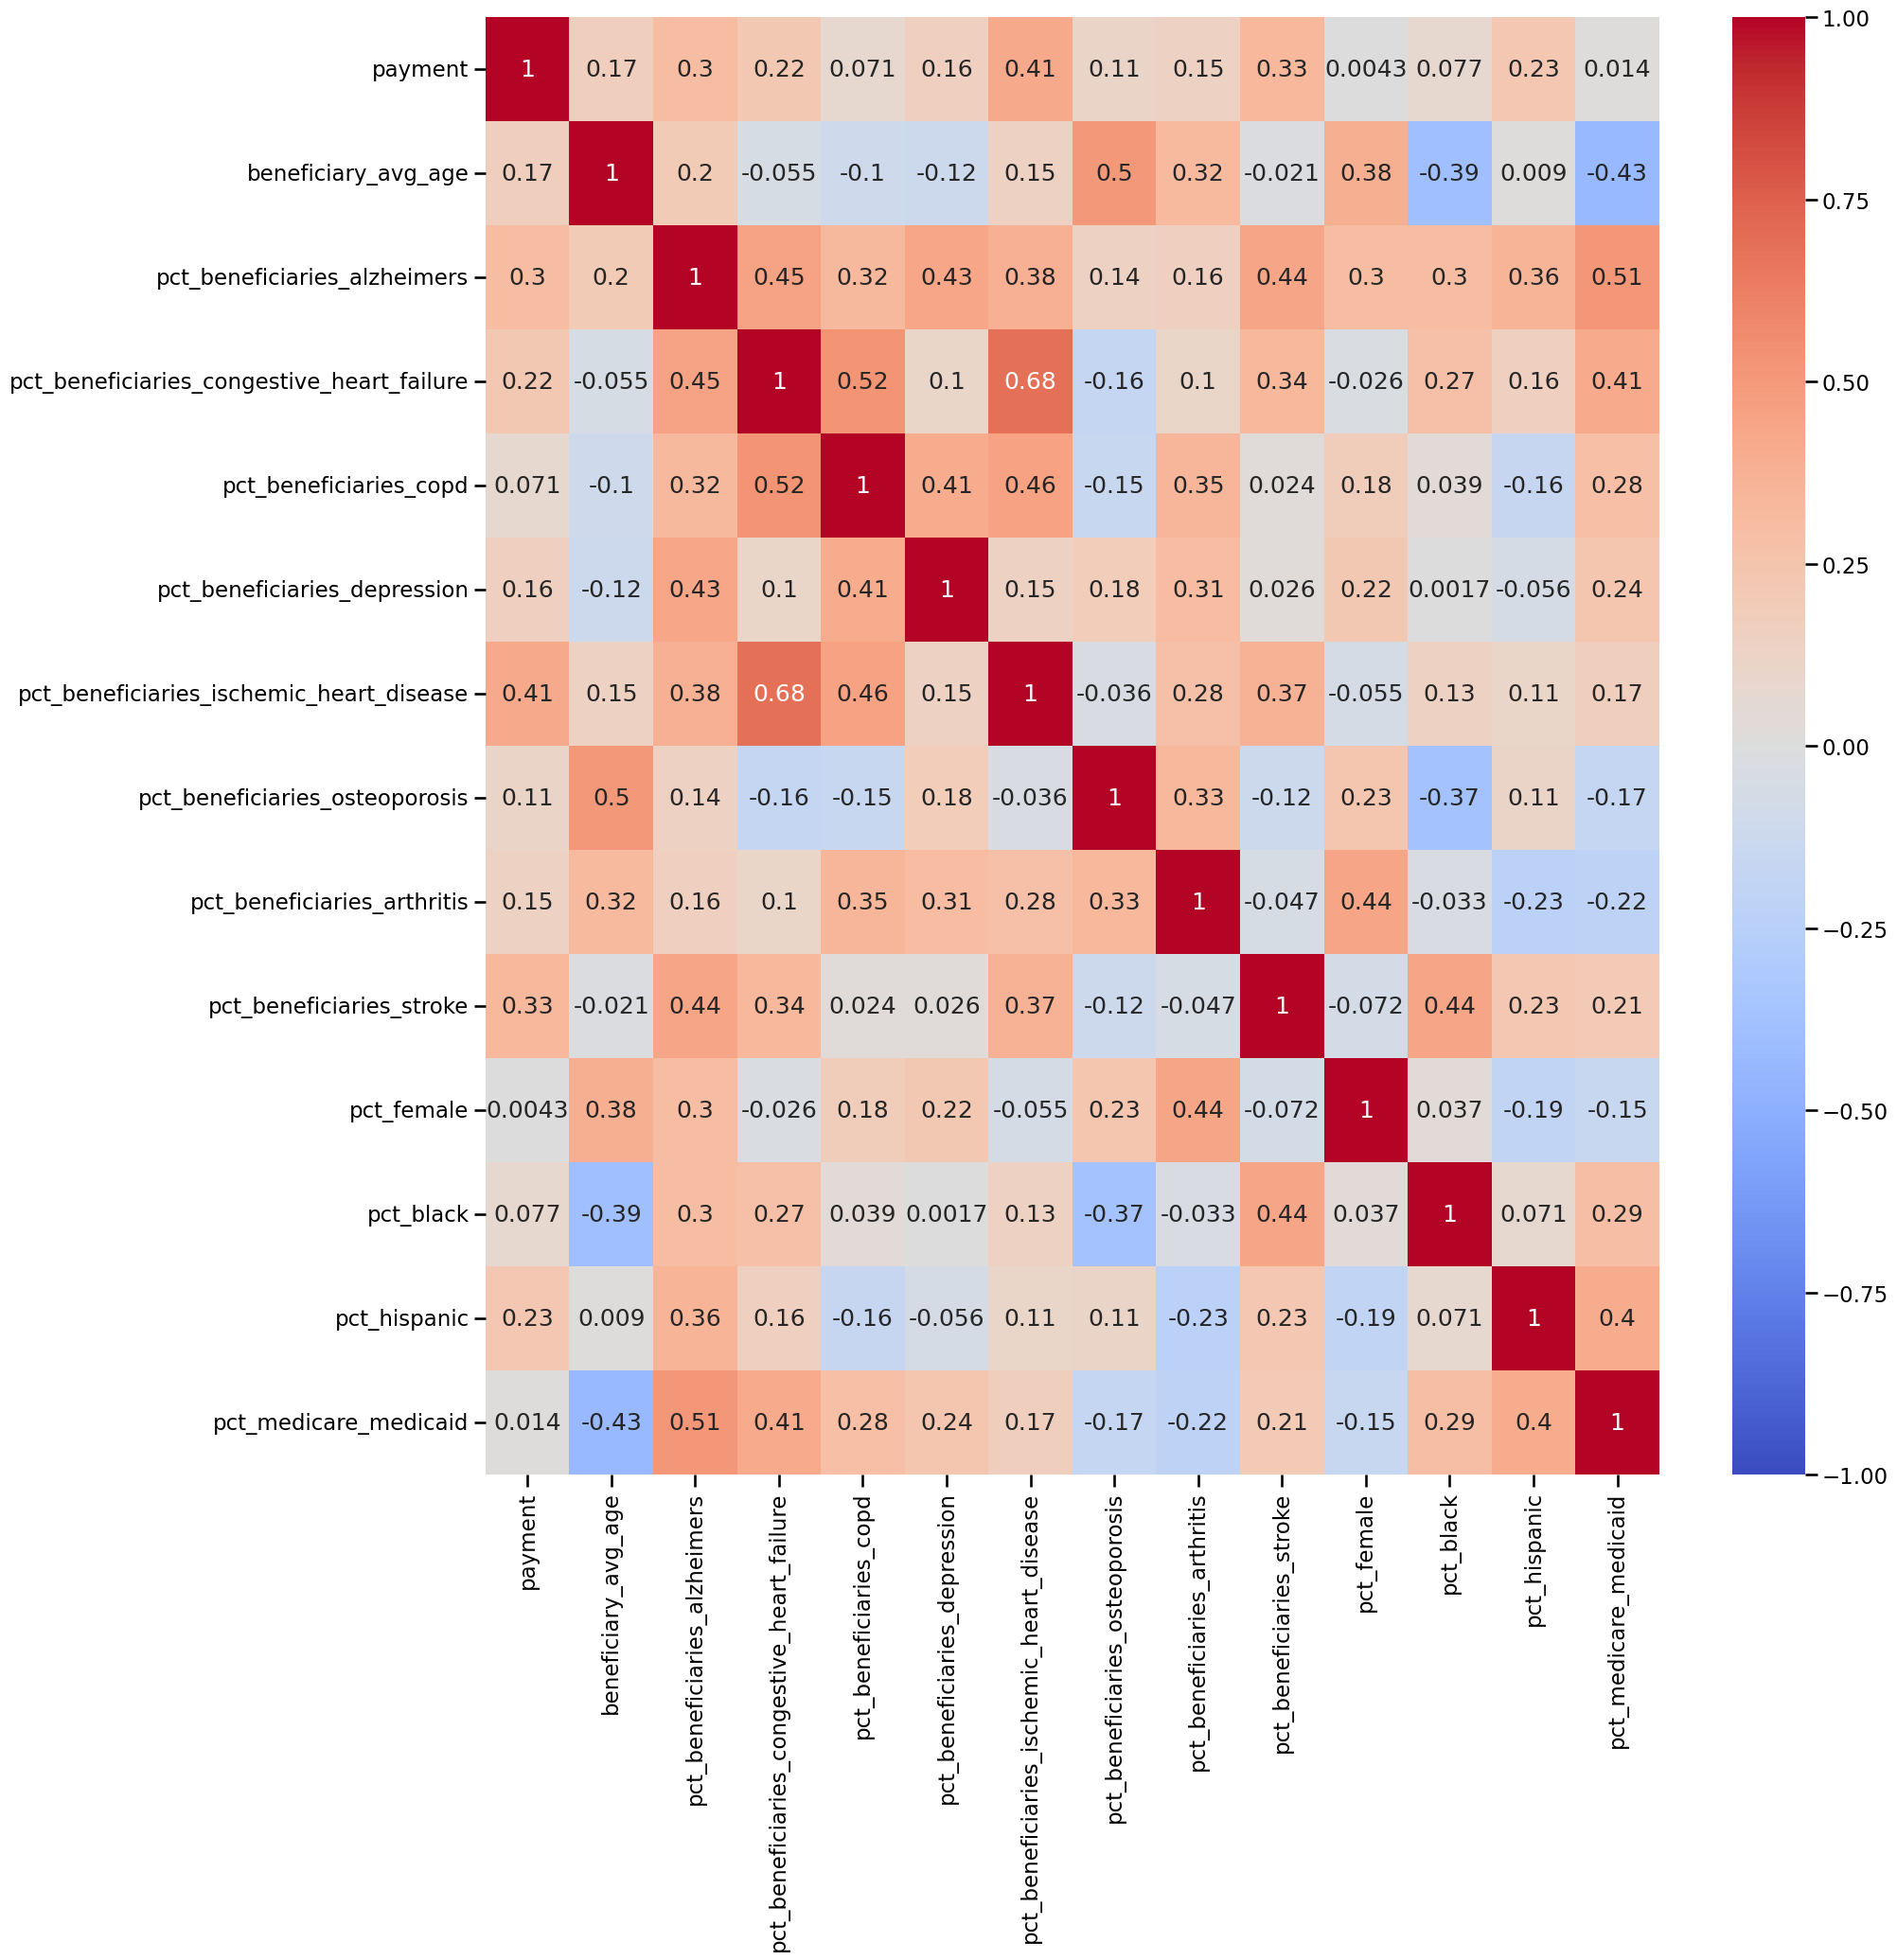

In [312]:
corr = X_standardized.corr()
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=ax)

### NOT IN USE CURRENTLY!!!

In [190]:
# A == BASE MODEL + RACE
features_A = [
    "payment",
    "beneficiary_avg_age",
    "pct_beneficiaries_afib",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_chronic_kidney_disease",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_congestive_heart_failure",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_depression",
    "pct_beneficiaries_diabetes",
    "pct_beneficiaries_osteoporosis",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_stroke",
    "pct_female",
    "pct_medicare_medicaid",
    "pct_medicare_only",
    # "pct_beneficiaries_psychotic_disorders",
    "pct_black",
    "pct_hispanic",
    "pct_white",
    "pct_medicare_only",
]

# # B == BASE MODEL

features_B = [
    "payment",
    "beneficiary_avg_age",
    "pct_beneficiaries_afib",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_cancer",
    "pct_beneficiaries_chronic_kidney_disease",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_congestive_heart_failure",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_depression",
    "pct_beneficiaries_diabetes",
    "pct_beneficiaries_osteoporosis",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_stroke",
    "pct_female",
    "pct_medicare_medicaid",
    # "pct_beneficiaries_psychotic_disorders",
    "pct_medicare_only",
]

X = model_df.drop(columns=["readmission_rate"])
X_standardized = process_features(model_df, features_A)
X_standardized.reset_index(drop=True, inplace=True)
y = df["readmission_rate"]
y.reset_index(drop=True, inplace=True)

KeyError: "['pct_beneficiaries_afib', 'pct_beneficiaries_cancer', 'pct_beneficiaries_chronic_kidney_disease', 'pct_beneficiaries_diabetes', 'pct_medicare_only', 'pct_white'] not in index"

Text(0.5, 1.0, 'R2')

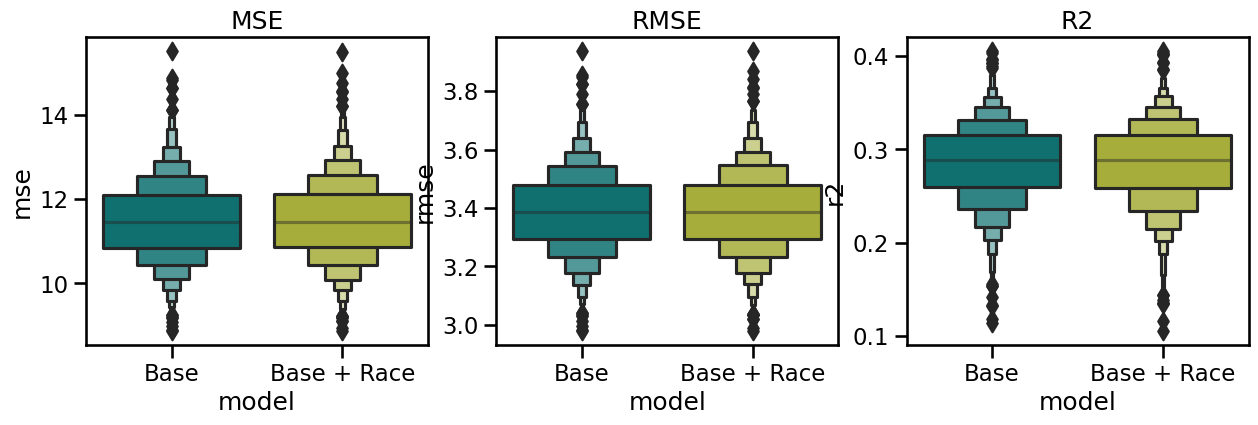

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
pal = ["#008080", "#B7C027"]
sns.boxenplot(data=results_df, x="model", y="mse", dodge=False, ax=ax[0], palette=pal)
sns.boxenplot(data=results_df, x="model", y="rmse", dodge=False, ax=ax[1], palette=pal)
sns.boxenplot(data=results_df, x="model", y="r2", dodge=False, ax=ax[2], palette=pal)

ax[0].set_title("MSE")
ax[1].set_title("RMSE")
ax[2].set_title("R2")

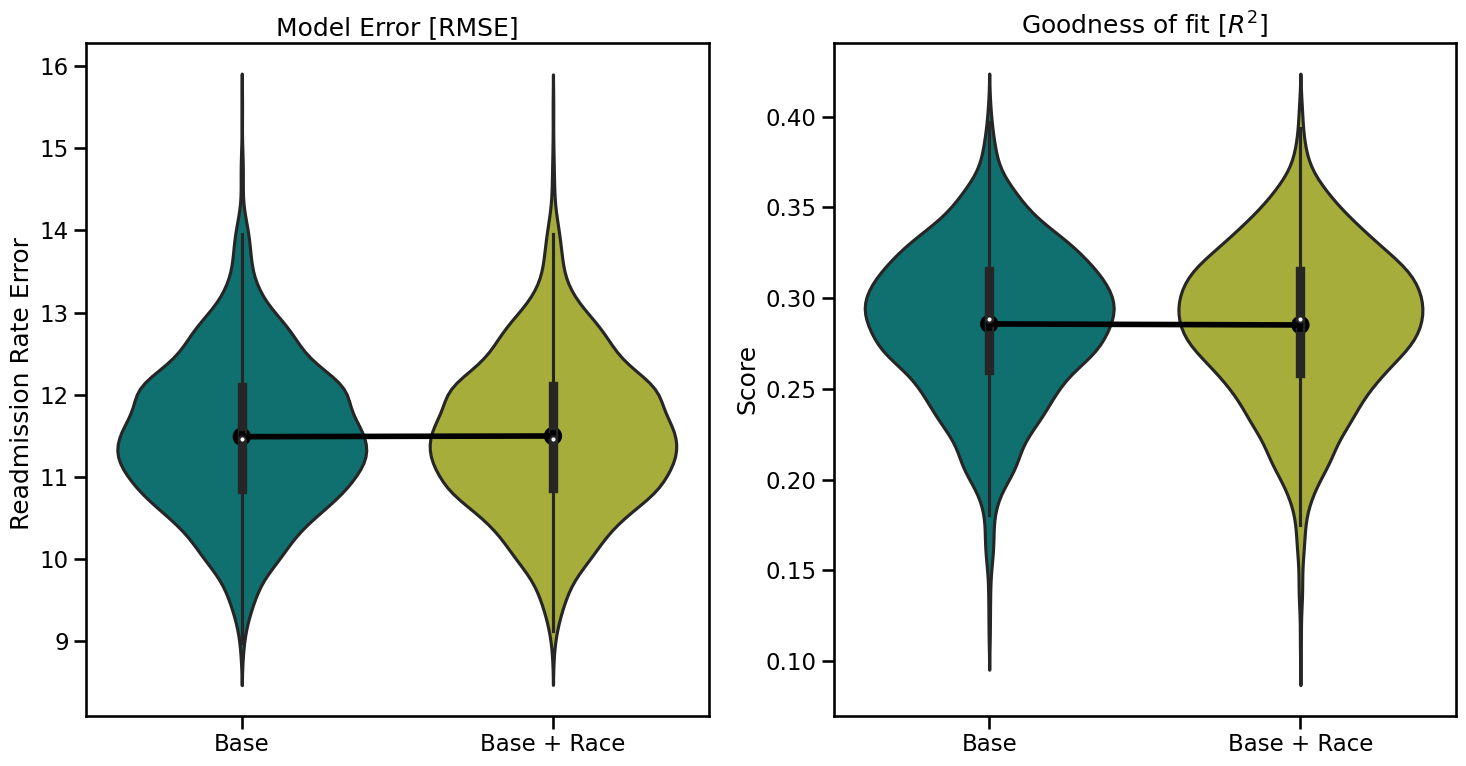

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# sns.boxenplot(data=results_df, x="model", y="mse", dodge=False, ax=ax[0], palette=pal)
sns.violinplot(data=results_df, x="model", y="mse", dodge=False, ax=ax[0], palette=pal)
sns.pointplot(data=results_df, x="model", y="mse", ax=ax[0], color="k")
sns.violinplot(data=results_df, x="model", y="r2", dodge=False, ax=ax[1], palette=pal)
sns.pointplot(data=results_df, x="model", y="r2", ax=ax[1], color="k")

# ax[0].set_title("MSE")
ax[0].set_title("Model Error [RMSE]")
ax[1].set_title("Goodness of fit [$R^2$]")
ax[0].set(xlabel=(""), ylabel=("Readmission Rate Error "))
ax[1].set(xlabel=(""), ylabel=("Score"))
plt.tight_layout()

In [27]:
# Separate MSE scores for models A and B
mse_A = results_df[results_df["model"] == "Base + Race"]["mse"]
mse_B = results_df[results_df["model"] == "Base"]["mse"]

# Perform a paired t-test
t_statistic, p_value = ttest_rel(mse_A, mse_B)

print("Paired t-test results:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

# Interpret the p-value to determine if the models are significantly different
alpha = 0.05  # Significance level
if p_value < alpha:
    print("The models are significantly different.")
else:
    print("There is no significant difference between the models.")

Paired t-test results:
t-statistic: 4.8339397223358205
p-value: 1.4406284625630187e-06
The models are significantly different.


In [29]:
results_df.head()

iteration model        mse      rmse        r2   payment  \
0          0  Base  12.192106  3.491720  0.279707  0.618938   
1          1  Base  11.111851  3.333444  0.295110  0.523268   
2          2  Base  11.090951  3.330308  0.328098  0.564899   
3          3  Base  12.689064  3.562171  0.258144  0.612099   
4          4  Base  10.840506  3.292492  0.282248  0.548196   

   beneficiary_avg_age  pct_beneficiaries_afib  pct_beneficiaries_alzheimers  \
0            -1.066407               -0.068565                      0.893862   
1            -0.975373               -0.056125                      0.827384   
2            -0.869391               -0.209506                      0.930403   
3            -1.051959                0.088689                      0.813472   
4            -0.911304               -0.110148                      0.884964   

   pct_beneficiaries_cancer  ...  pct_beneficiaries_stroke_p_val  \
0                  0.248568  ...                        0.016063   
1                  0.135319  ...                        0.005431   
2                  0.111936  ...                        0.018229   
3                  0.180047  ...                        0.007550   
4                  0.136681  ...                        0.009898   

   pct_female_p_val  pct_medicare_medicaid_p_val  \
0          0.000701                     0.160829   
1          0.005877                     0.277683   
2          0.060608                     0.948551   
3          0.003933                     0.478803   
4          0.031157                     0.309387   

                             pct_medicare_only_p_val  pct_black  pct_hispanic  \
0  pct_medicare_only    0.988664
pct_medicare_onl...        NaN           NaN   
1  pct_medicare_only    0.569983
pct_medicare_onl...        NaN           NaN   
2  pct_medicare_only    0.173809
pct_medicare_onl...        NaN           NaN   
3  pct_medicare_only    0.355623
pct_medicare_onl...        NaN           NaN   
4  pct_medicare_only    0.580952
pct_medicare_onl...        NaN           NaN   

   pct_white  pct_black_p_val  pct_hispanic_p_val  pct_white_p_val  
0        NaN              NaN                 NaN              NaN  
1        NaN              NaN                 NaN              NaN  
2        NaN              NaN                 NaN              NaN  
3        NaN              NaN                 NaN              NaN  
4        NaN              NaN                 NaN              NaN  

[5 rows x 45 columns]

In [37]:
p_val_df = results_df.filter(like="_p_val")
p_val_df = pd.concat([results_df["model"], p_val_df], axis=1)
p_val_df = p_val_df.drop(columns=["pct_medicare_only_p_val"])

In [58]:
features_A_p_vals = [
    f"{feat}_p_val" for feat in features_A if feat != "pct_medicare_only"
]

In [59]:
p_val_A_mean = p_val_df[p_val_df["model"] == "Base + Race"][features_A_p_vals].mean()
p_val_A_std = p_val_df[p_val_df["model"] == "Base + Race"][features_A_p_vals].std()

p_val_B_mean = p_val_df[p_val_df["model"] == "Base"][features_A_p_vals].mean()
p_val_B_std = p_val_df[p_val_df["model"] == "Base"][features_A_p_vals].std()

# # Sort p_val for model A by absolute value in descending order
# p_val_A_sorted_idx = np.abs(p_val_A_mean).sort_values(ascending=True).index
# p_val_A_mean_sorted = p_val_A_mean[p_val_A_sorted_idx]
# p_val_A_std_sorted = p_val_A_std[p_val_A_sorted_idx]
# custom_sort_order_A = np.lexsort((np.abs(p_val_A_mean), themes))
# p_val_A_mean_sorted = p_val_A_mean.iloc[custom_sort_order_A]
# p_val_A_std_sorted = p_val_A_std.iloc[custom_sort_order_A]

# Sort p_val for model B using the same sorting order as model A
# p_val_B_mean_sorted = p_val_B_mean[p_val_A_sorted_idx]
# p_val_B_std_sorted = p_val_B_std[p_val_A_sorted_idx]
# p_val_B_mean_sorted = p_val_B_mean.iloc[custom_sort_order_A]
# p_val_B_std_sorted = p_val_B_std.iloc[custom_sort_order_A]

# custom_y_labels = (
#     [  # have to make plot first and then can write out these short hand labels
#         "N White",
#         "N Hispanic",
#         "N Black",
#         "N Medicare Only",
#         "N Dual Enroll.",
#         "Avg Payment",
#         "Avg Age",
#         "% Psych. Dis.",
#         "% COPD",
#         "% AD",
#         "% Arth.",
#         "% Stroke",
#         "% Osteo.",
#         "% Cancer",
#         "% Diabetes",
#     ]
# )

In [60]:
p_val_A_mean

payment_p_val                                       5.366499e-07
beneficiary_avg_age_p_val                           4.491222e-05
pct_beneficiaries_afib_p_val                        7.095929e-01
pct_beneficiaries_alzheimers_p_val                  3.654986e-04
pct_beneficiaries_cancer_p_val                      5.911782e-01
pct_beneficiaries_chronic_kidney_disease_p_val      7.146691e-01
pct_beneficiaries_copd_p_val                        3.469746e-05
pct_beneficiaries_congestive_heart_failure_p_val    4.724415e-02
pct_beneficiaries_ischemic_heart_disease_p_val      1.431990e-02
pct_beneficiaries_depression_p_val                  7.806853e-03
pct_beneficiaries_diabetes_p_val                    6.587972e-01
pct_beneficiaries_osteoporosis_p_val                8.888658e-02
pct_beneficiaries_arthritis_p_val                   7.896288e-02
pct_beneficiaries_stroke_p_val                      6.558757e-02
pct_female_p_val                                    2.656647e-02
pct_medicare_medicaid_p_v

(-0.05, 0.05)

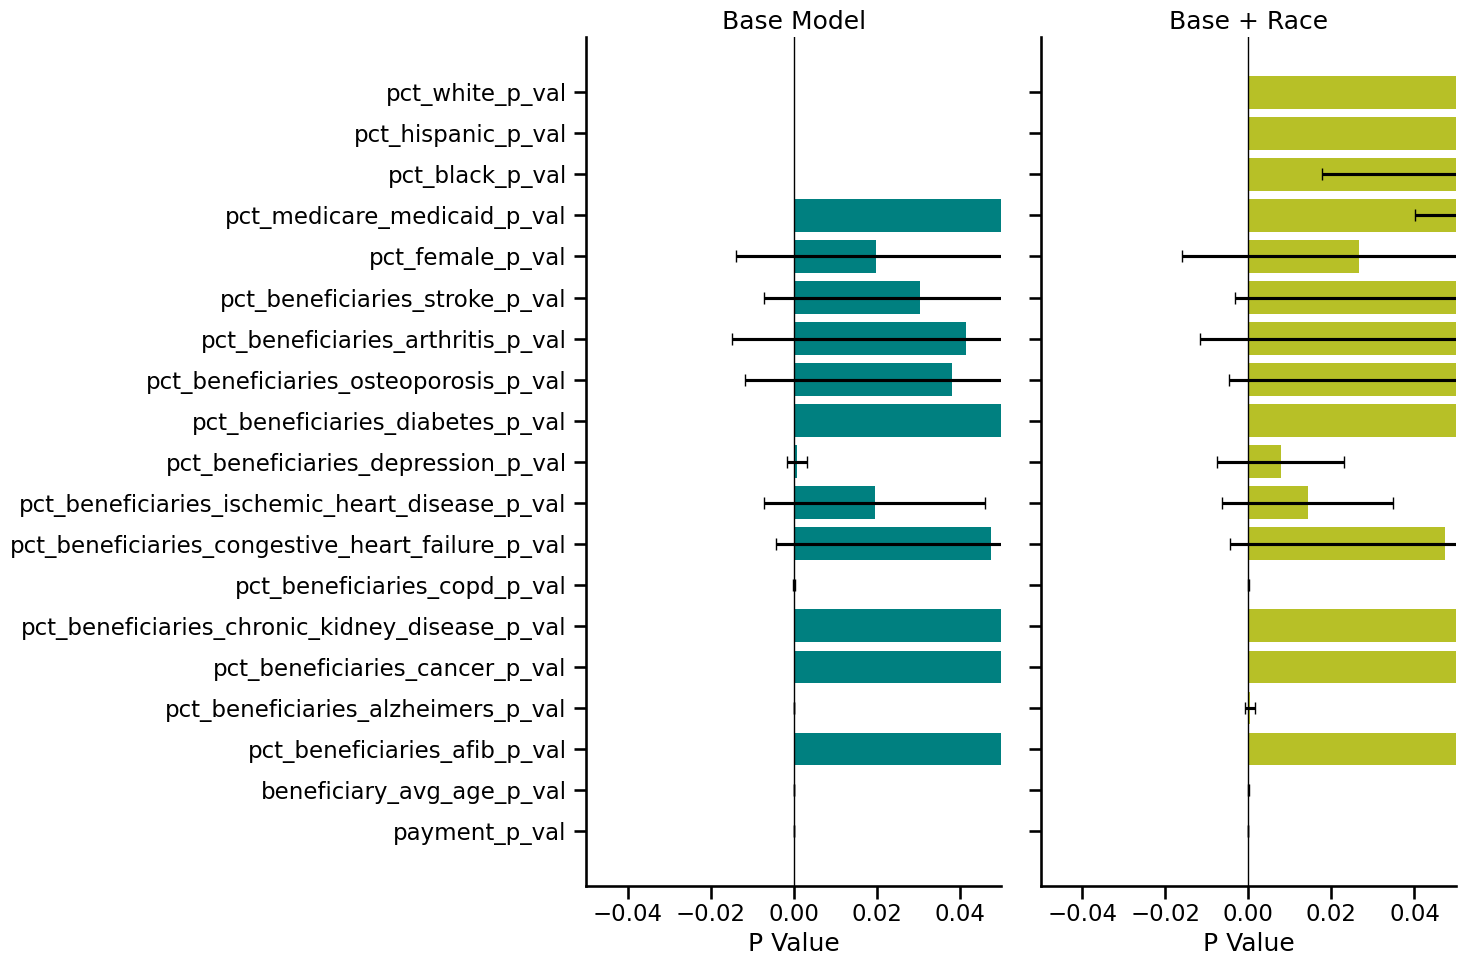

In [67]:
# Create a fig
fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey=True, sharex=True)
sns.set_context("talk")
# Plot coefficients for model A with error bars
axs[1].barh(
    p_val_A_mean.index,
    p_val_A_mean.values,
    xerr=p_val_A_std,
    capsize=4,
    color=pal[1],
)
axs[1].set_title("Base + Race")
axs[1].set_xlabel("P Value")

# Plot coefficients for model B with error bars
axs[0].barh(
    p_val_B_mean.index,
    p_val_B_mean.values,
    xerr=p_val_B_std,
    capsize=4,
    color=pal[0],
)

axs[0].set_title("Base Model")
axs[0].set_xlabel("P Value")
# axs[0].set_ylabel("Features")
# axs[0].set_yticks(range(len(custom_y_labels)))
# axs[0].set_yticklabels(custom_y_labels)
axs[0].yaxis.set_tick_params(pad=5)


for ax in axs:
    ax.axvline(x=0, color="black", linewidth=1)
# Adjust layout and display the plot
plt.tight_layout()
sns.despine()
plt.xlim(-0.05, 0.05)

In [68]:
results_df_transformed = results_df.copy()

for col in log_transform:
    results_df[col] = 10 ** (results_df[col])

for col in power_transform:
    results_df[col] = (results_df[col]) ** (1 / 2)

In [69]:
results_df

iteration        model        mse      rmse        r2   payment  \
0             0         Base  12.192106  3.491720  0.279707  0.618938   
1             1         Base  11.111851  3.333444  0.295110  0.523268   
2             2         Base  11.090951  3.330308  0.328098  0.564899   
3             3         Base  12.689064  3.562171  0.258144  0.612099   
4             4         Base  10.840506  3.292492  0.282248  0.548196   
...         ...          ...        ...       ...       ...       ...   
3995       1995  Base + Race  11.989267  3.462552  0.303889  0.611929   
3996       1996  Base + Race  11.420922  3.379485  0.264050  0.637617   
3997       1997  Base + Race  12.253795  3.500542  0.301854  0.519239   
3998       1998  Base + Race  11.464562  3.385936  0.251906  0.627226   
3999       1999  Base + Race  10.866540  3.296444  0.312039  0.590801   

      beneficiary_avg_age  pct_beneficiaries_afib  \
0               -1.066407               -0.068565   
1               -0.975373               -0.056125   
2               -0.869391               -0.209506   
3               -1.051959                0.088689   
4               -0.911304               -0.110148   
...                   ...                     ...   
3995            -0.897906               -0.003816   
3996            -0.963801                0.152520   
3997            -0.978265                0.081826   
3998            -0.944224               -0.011927   
3999            -0.939516                0.016550   

      pct_beneficiaries_alzheimers  pct_beneficiaries_cancer  ...  \
0                         0.893862                  0.248568  ...   
1                         0.827384                  0.135319  ...   
2                         0.930403                  0.111936  ...   
3                         0.813472                  0.180047  ...   
4                         0.884964                  0.136681  ...   
...                            ...                       ...  ...   
3995                      0.731680                  0.113690  ...   
3996                      0.804815                 -0.003441  ...   
3997                      0.760652                  0.114948  ...   
3998                      0.699547                  0.034169  ...   
3999                      0.812119                  0.141386  ...   

      pct_beneficiaries_stroke_p_val  pct_female_p_val  \
0                           0.016063          0.000701   
1                           0.005431          0.005877   
2                           0.018229          0.060608   
3                           0.007550          0.003933   
4                           0.009898          0.031157   
...                              ...               ...   
3995                        0.061654          0.003195   
3996                        0.142460          0.003222   
3997                        0.070286          0.022896   
3998                        0.010771          0.000803   
3999                        0.150471          0.006278   

      pct_medicare_medicaid_p_val  \
0                        0.160829   
1                        0.277683   
2                        0.948551   
3                        0.478803   
4                        0.309387   
...                           ...   
3995                     0.065968   
3996                     0.319825   
3997                     0.135505   
3998                     0.823168   
3999                     0.141536   

                                pct_medicare_only_p_val  pct_black  \
0     pct_medicare_only    0.988664
pct_medicare_onl...        NaN   
1     pct_medicare_only    0.569983
pct_medicare_onl...        NaN   
2     pct_medicare_only    0.173809
pct_medicare_onl...        NaN   
3     pct_medicare_only    0.355623
pct_medicare_onl...        NaN   
4     pct_medicare_only    0.580952
pct_medicare_onl...        NaN   
...                                                 ...        ...   
3995  pct_medicare_only    0.60

In [70]:
# for col in log_transform:
#     results_df[col] = 10 ** (results_df[col])

# Calculate mean coefficients and standard deviations for models A and B
coefficients_A_mean = results_df[results_df["model"] == "Base + Race"][
    features_A
].mean()
coefficients_A_std = results_df[results_df["model"] == "Base + Race"][features_A].std()

coefficients_B_mean = results_df[results_df["model"] == "Base"][features_A].mean()
coefficients_B_std = results_df[results_df["model"] == "Base"][features_A].std()

# Sort coefficients for model A by absolute value in descending order
coefficients_A_sorted_idx = (
    np.abs(coefficients_A_mean).sort_values(ascending=True).index
)
coefficients_A_mean_sorted = coefficients_A_mean[coefficients_A_sorted_idx]
coefficients_A_std_sorted = coefficients_A_std[coefficients_A_sorted_idx]
# custom_sort_order_A = np.lexsort((np.abs(coefficients_A_mean), themes))
# coefficients_A_mean_sorted = coefficients_A_mean.iloc[custom_sort_order_A]
# coefficients_A_std_sorted = coefficients_A_std.iloc[custom_sort_order_A]

# Sort coefficients for model B using the same sorting order as model A
coefficients_B_mean_sorted = coefficients_B_mean[coefficients_A_sorted_idx]
coefficients_B_std_sorted = coefficients_B_std[coefficients_A_sorted_idx]
# coefficients_B_mean_sorted = coefficients_B_mean.iloc[custom_sort_order_A]
# coefficients_B_std_sorted = coefficients_B_std.iloc[custom_sort_order_A]

# custom_y_labels = (
#     [  # have to make plot first and then can write out these short hand labels
#         "N White",
#         "N Hispanic",
#         "N Black",
#         "N Medicare Only",
#         "N Dual Enroll.",
#         "Avg Payment",
#         "Avg Age",
#         "% Psych. Dis.",
#         "% COPD",
#         "% AD",
#         "% Arth.",
#         "% Stroke",
#         "% Osteo.",
#         "% Cancer",
#         "% Diabetes",
#     ]
# )

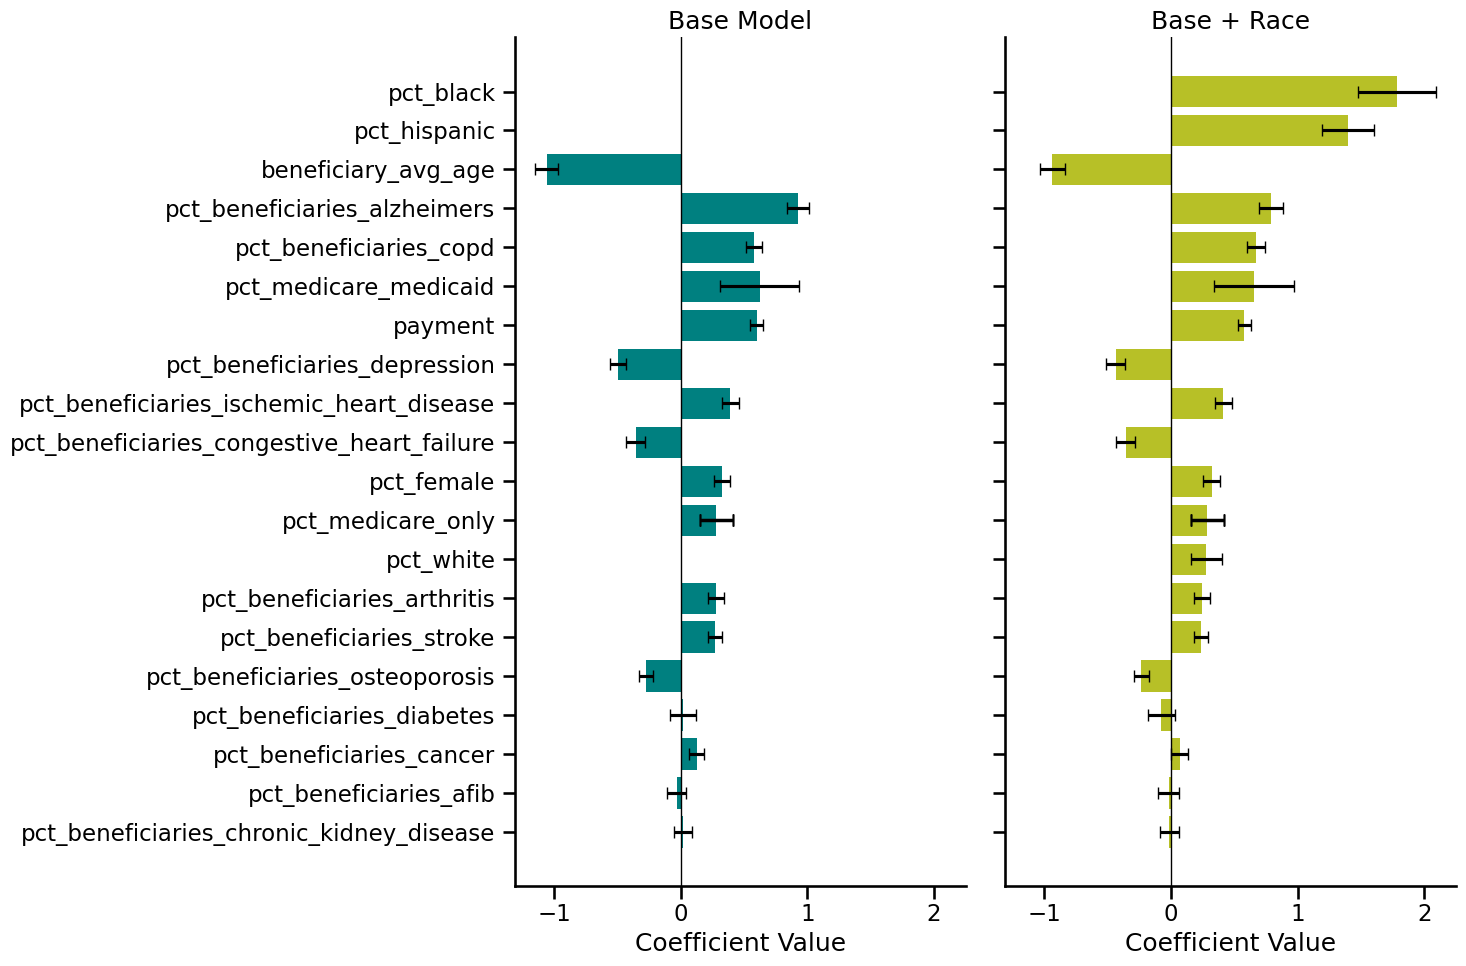

In [71]:
# Create a fig
fig, axs = plt.subplots(1, 2, figsize=(15, 10), sharey=True, sharex=True)
sns.set_context("talk")
# Plot coefficients for model A with error bars
axs[1].barh(
    coefficients_A_mean_sorted.index,
    coefficients_A_mean_sorted.values,
    xerr=coefficients_A_std_sorted,
    capsize=4,
    color=pal[1],
)
axs[1].set_title("Base + Race")
axs[1].set_xlabel("Coefficient Value")

# Plot coefficients for model B with error bars
axs[0].barh(
    coefficients_B_mean_sorted.index,
    coefficients_B_mean_sorted.values,
    xerr=coefficients_B_std_sorted,
    capsize=4,
    color=pal[0],
)

axs[0].set_title("Base Model")
axs[0].set_xlabel("Coefficient Value")
# axs[0].set_ylabel("Features")
# axs[0].set_yticks(range(len(custom_y_labels)))
# axs[0].set_yticklabels(custom_y_labels)
axs[0].yaxis.set_tick_params(pad=5)


for ax in axs:
    ax.axvline(x=0, color="black", linewidth=1)
# Adjust layout and display the plot
plt.tight_layout()
sns.despine()

/Users/jessbreda/anaconda3/envs/ds4a_py310/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


[Text(0.5, 0, 'avg_number_black_beneficiaries_py'),
 Text(0, 0.5, 'readmission_rate')]

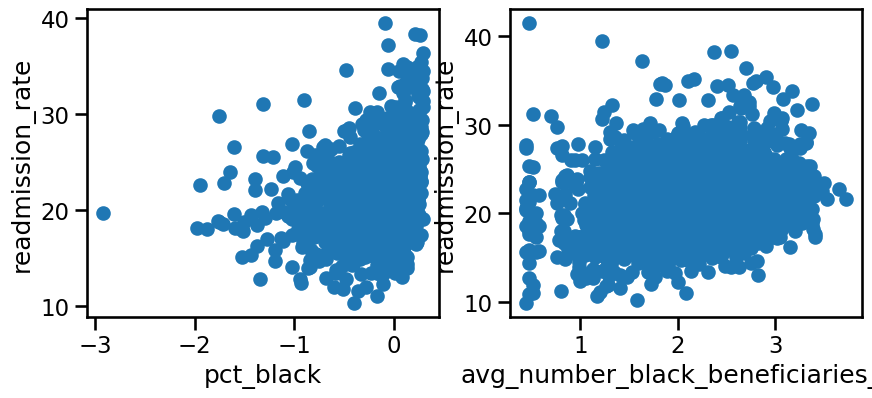

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter(np.log10(df.pct_black), df.readmission_rate)
ax[1].scatter(np.log10(df.avg_number_black_beneficiaries_py), df.readmission_rate)
ax[0].set(xlabel="pct_black", ylabel="readmission_rate")
ax[1].set(xlabel="avg_number_black_beneficiaries_py", ylabel="readmission_rate")

In [17]:
df.pct_white.max()

9648.945022992464

[Text(0.5, 0, 'avg_number_white_beneficiaries_py (log10)'),
 Text(0, 0.5, 'readmission_rate')]

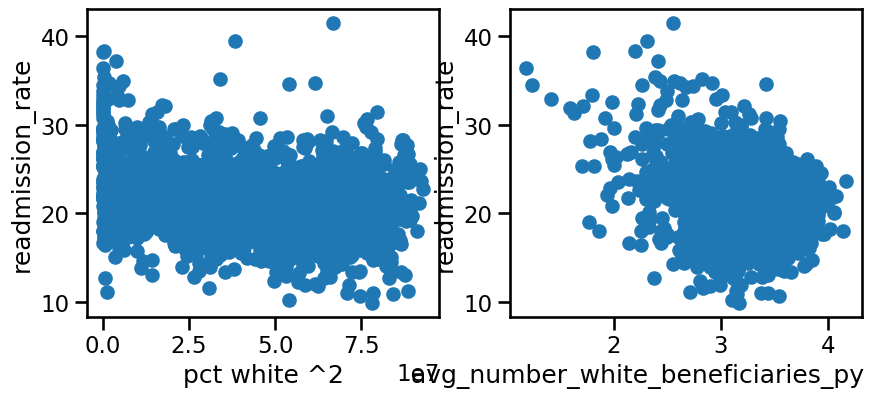

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].scatter((df.pct_white) ** 2, df.readmission_rate)
ax[1].scatter(np.log10(df.avg_number_white_beneficiaries_py), df.readmission_rate)
ax[0].set(xlabel="pct white ^2", ylabel="readmission_rate")
ax[1].set(xlabel="avg_number_white_beneficiaries_py (log10)", ylabel="readmission_rate")

Text(0.5, 0, 'Percent Black')

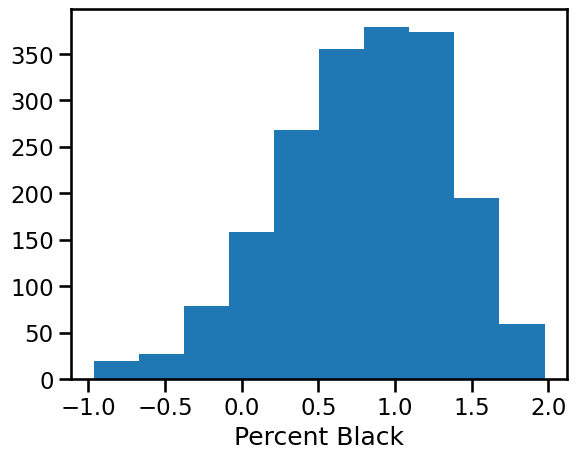

In [19]:
plt.hist((df.pct_black))
plt.xlabel("Percent Black")

In [20]:
df["pct_white"] = (
    100 * df["number_white_beneficiaries"] / df["total_medicare_beneficiaries"]
)
df["pct_black"] = (
    100 * df["number_black_beneficiaries"] / df["total_medicare_beneficiaries"]
)
df["pct_asian_pi"] = (
    100 * df["number_asian_pi_beneficiaries"] / df["total_medicare_beneficiaries"]
)
df["pct_hispanic"] = (
    100 * df["number_hispanic_beneficiaries"] / df["total_medicare_beneficiaries"]
)
df["pct_american_indian"] = (
    100
    * df["number_american_indian_beneficiaries"]
    / df["total_medicare_beneficiaries"]
)
df["pct_other_race"] = (
    100 * df["number_other_race_beneficiaries"] / df["total_medicare_beneficiaries"]
)
df["pct_medicare_medicaid"] = (
    100
    * df["number_beneficiaries_medicare_medicaid"]
    / df["total_medicare_beneficiaries"]
)
df["pct_medicare_only"] = (
    100
    * df["number_beneficiaries_medicare_only"]
    / df["total_medicare_beneficiaries"](edited)
)

KeyError: 'number_white_beneficiaries'